In [1]:
%pylab inline
import matplotlib
matplotlib.rcParams['figure.figsize']=(12,10)
import webbpsf
from copy import deepcopy
import os.path
import jwst_pancake
from jwst_pancake import engine as pcengine
from jwst_pancake import wfsc
from jwst_pancake.wfsc import display_mimf_etc_results


Populating the interactive namespace from numpy and matplotlib


# Calculating Exposures for Defocused PSFs using Pandeia-WFSC

* [NIRCam with 8 waves for Routine WFSC](#NIRCam-8-waves,-for-routine-WFSC)
* [MIMF PSF calculations](#MIMF-PSF-calculations)
  * [NIRCam with 4 waves defocus](#NIRCam-with-4-waves,-for-MIMF)
  * [NIRISS with 4 waves defocus](#NIRISS-with-4-waves-defocus,-for-MIMF)
  * [NIRSpec with 4 waves defocus](#NIRSpec-with-4-waves-defocus,-for-MIMF)
  * [MIRI with 4 waves defocus](#MIRI-with-4-waves-defocus,-for-MIMF)
  * [FGS with 4 waves defocus](#FGS-with-4-waves-defocus,-for-MIMF)





The `wfsc` branch adds support for custom on-the-fly PSFs in modes other than coronagraphy, intended for WFSC calculations with weird OTE commissioning PSFs. 

Most of the calculation machinery is in the `wfsc.py` file in `pandeia_coronagraphy`.  

<font color='red'> ** DISCLAIMER: THE FGS PART OF THIS REQUIRES A CUSTOM MODIFIED VERSION OF PANDEIA REFDATA - THIS IS OFFICIALLY 100% UNSUPPORTED (EVEN LESS SUPPORTED THAN THE REST OF JWST_PANCAKE - AND IS NOT INTENDED FOR USE OUTSIDE OF STSCI **</font>

The other instruments all work with the default Pandeia 1.5 setups, plus `jwst_pancake` with the `wfsc` branch.

First we show examples for all of the instruments, then we show how to adjust the target properties

## Setup and installation

* Make sure you have Pandeia engine v 1.5.2 installed, along with its reference data
* You may need to update dependencies, in particular installing `stsynphot` now (as well as `synphot`? Ugh, the multiple synphot variants are not helpful.)
* Check out this branch `wfsc` of `jwst_pancake`

## General theory of operation

For each SI, there are template files included with `pandeia_coronagraphy.wfsc`. These define the basic observational setup for each mode (in terms of instrument, mode, filters, etc). These were created by modifying the templates provided with Pandeia to more closely represent the APT setups for OTE WFSC observations.  Generally you will start by loading one of these:

In [2]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))

For OTE WFSC calculations, you will want to defocus the telescope. Note, calling this function will automatically enable the "on the fly PSFs" mode in the Pandeia-coronagraphy engine, if it's not already set to true. 

In [3]:
wfsc.configure_telescope(defocus_waves=4)  # Waves at 2 microns

Enabling on-the-fly PSFs for ETC calculations


Then you may wish to adjust the the input star properties or exposure parameters. There are utility functions for this, which provide a more convenient syntax than manually editing the values in the multi-layered nested dicts that Pandeia uses. 

*(TODO: move these setup helper functions into master and use it for coronagraphy too?)*

In [4]:
wfsc.configure_star(calcinfo, kmag=9, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=5, nint=1)

The Pandeia coronagraphy engine exposes various options which you can adjust, if desired. 

In [63]:
jwst_pancake.engine.options.wave_sampling = 3  # Optional, tweak for computation speed
jwst_pancake.engine.options.verbose = False # enable if you want diagnostics printed

# Basic case while debugging

In [6]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_ts_wlp8.json'))
#wfsc.configure_star(calcinfo, kmag=8, sptype='k2v')
#wfsc.configure_readout(calcinfo, ngroup=10, nint=5)
#wfsc.configure_telescope(defocus_waves=8)  # Waves at 2 microns
#results_nircam_wl8 = pcengine.perform_calculation(calcinfo)
#display_mimf_etc_results(results_nircam_wl8)

In [7]:
calcinfo['configuration']
wfsc.configure_readout(calcinfo, ngroup=10, nint=5, readout_pattern='rapid')
calcinfo['configuration']
wfsc.configure_star(calcinfo, kmag=7, sptype='k5v')
calcinfo['scene']

[{'id': 1,
  'position': {'orientation': 0.0, 'x_offset': 0.0, 'y_offset': 0.0},
  'shape': {'geometry': 'point'},
  'spectrum': {'extinction': {'bandpass': 'j',
    'law': 'mw_rv_31',
    'unit': 'mag',
    'value': 0},
   'lines': [],
   'normalization': {'bandpass': 'bessell,k',
    'norm_flux': 7,
    'norm_fluxunit': 'vegamag',
    'type': 'photsys'},
   'redshift': 0,
   'sed': {'key': 'k5v', 'sed_type': 'phoenix'}}}]

## ETC consistency cross check: In Focus PSF

Compare to ETC notebook 55449 calculation 4

SBR: 4117.193176396647
Mean count rate within mask: 1523.7 e-/sec
Total count rate: 21214.5 e-/sec


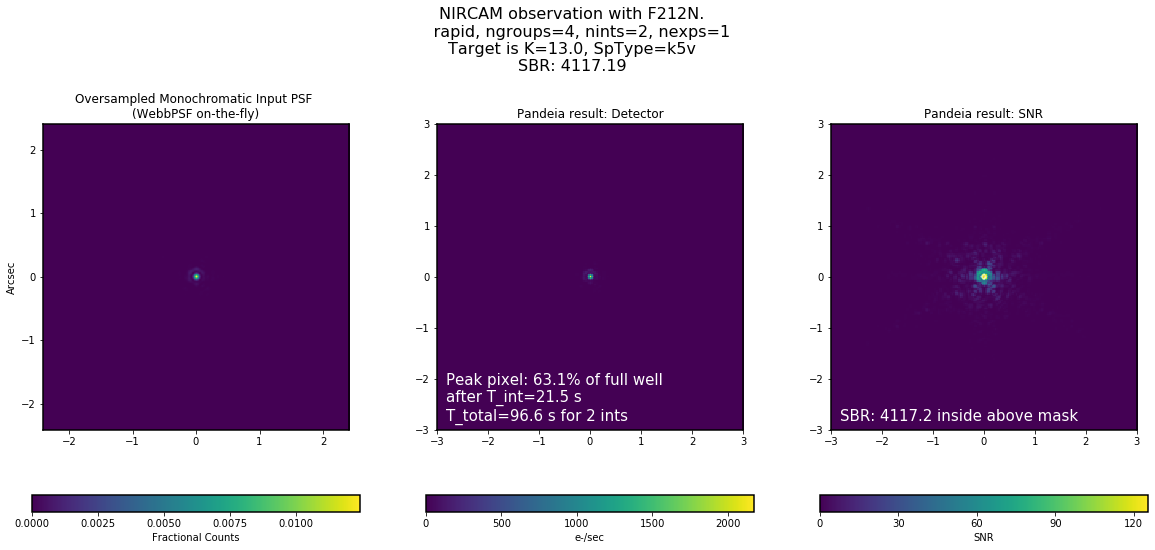

In [67]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=13, sptype='k5v')
wfsc.configure_readout(calcinfo, ngroup=4, nint=2)
wfsc.configure_telescope(defocus_waves=0)  # Waves at 2 microns ==> in focus

jwst_pancake.engine.options.on_the_fly_psf = False

results_nircam_infocus = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam_infocus)

In [68]:
# ETC web interface has 24986 counts, for 12th mag star
# We should expect here slightly larger since ETC PSF lib truncates the wings due to array size,
results_nircam_infocus['2d']['detector'].sum()

21214.513160243252

In [69]:
# And we expect about 2682 peak counts, for 12th mag star
# 1087 counts for 13th mag star. 
expected_peak = 1087
results_nircam_infocus['2d']['detector'].max(), results_nircam_infocus['2d']['detector'].max()/expected_peak

(2175.100316870181, 2.001012251030525)

That's relatively good agreement: within 3% is certainly good enough for ETC purposes

## ETC consistency cross check: 8 waves defocused PSF

Compare to ETC notebook 55449 calculation 1

CUSTOM PSF LIBRARY ACTIVATE!
DEBUG:jwst_pancake.pandeia_subclasses:CUSTOM PSF LIBRARY ACTIVATE!
CUSTOM PSF LIBRARY ACTIVATE!
DEBUG:jwst_pancake.pandeia_subclasses:CUSTOM PSF LIBRARY ACTIVATE!
CORONAGRAPHY SCENE CUBE ACTIVATE!
DEBUG:jwst_pancake.pandeia_subclasses:CORONAGRAPHY SCENE CUBE ACTIVATE!
Getting nircam wlp8__ts 2.0793... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam wlp8__ts 2.0793... with caching ram
 Cache Stats: CacheInfo(hits=6, misses=20, maxsize=256, currsize=20)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=6, misses=20, maxsize=256, currsize=20)
Getting nircam wlp8__ts 2.0793... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam wlp8__ts 2.0793... with caching ram
 Cache Stats: CacheInfo(hits=7, misses=20, maxsize=256, currsize=20)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=7, misses=20, maxsize=256, currsize=20)
Getting nircam wlp8__ts 2.121305... with caching ram
INFO:jwst_pancake.pan

Added latest on-the-fly PSF to results dict.
SBR: 911.2574118716359
Mean count rate within mask: 172.4 e-/sec
Total count rate: 2006755.4 e-/sec


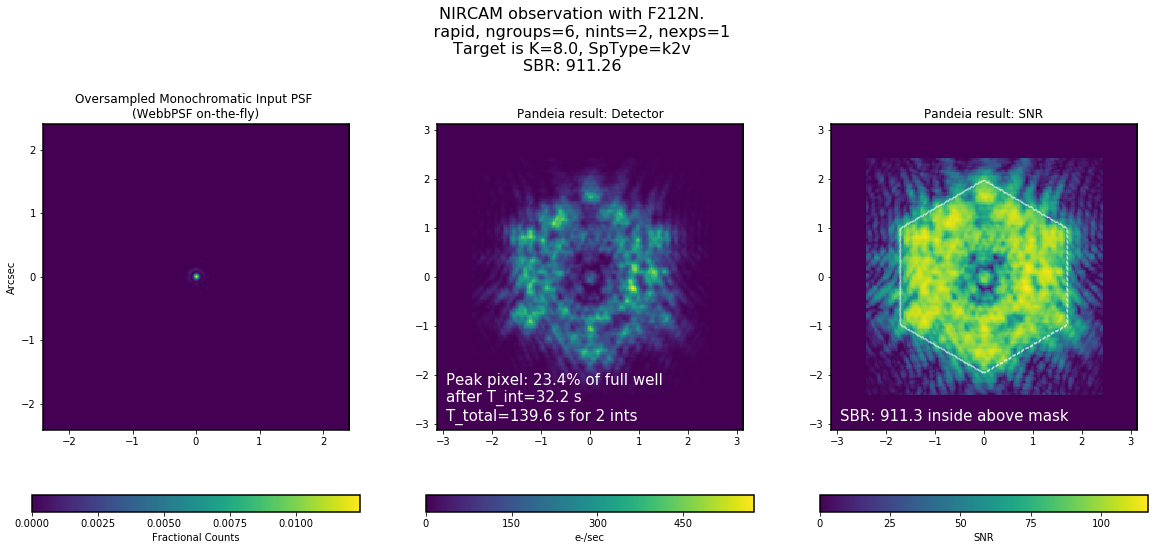

In [43]:
# Load an ETC template that configures in the WLP8 weak lens:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_ts_wlp8.json'))
wfsc.configure_star(calcinfo, kmag=8, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=6, nint=2)
wfsc.configure_telescope(defocus_waves=0)  # Waves at 2 microns ==> OTE in focus, 
results_nircam_wl8 = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam_wl8)

In [45]:
(results_nircam_wl8['2d']['detector'][results_nircam_wl8['mask']]).mean()

172.3502857269144

In [46]:
import astropy.io.fits as fits
etc_image = fits.getdata('wb55449_c1_2020-10-16_20.31.03/image/image_detector.fits')

In [47]:
etc_image.shape, results_nircam_wl8['2d']['detector'].shape

((201, 201), (201, 201))

In [50]:
(etc_image[results_nircam_wl8['mask']]).mean()

84.34963895361604

## TODO: figure out this factor of 2 discrepancy!!

Text(0.5, 1.0, 'From pancake')

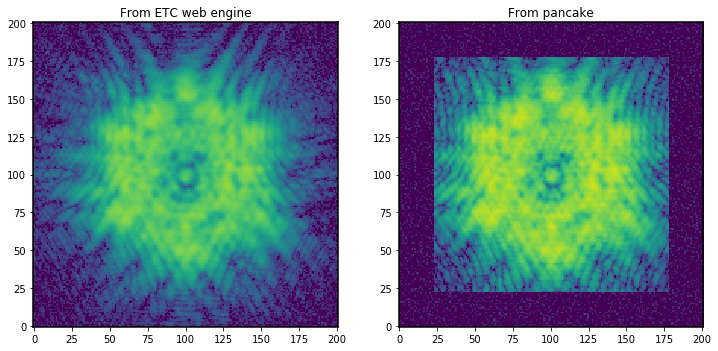

In [48]:
cm = matplotlib.cm.get_cmap('viridis')
cm.set_bad(cm(0))
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(etc_image, norm=matplotlib.colors.LogNorm(0.1, 1000), cmap=cm)
axes[0].set_title("From ETC web engine")
axes[1].imshow(results_nircam_wl8['2d']['detector'], norm=matplotlib.colors.LogNorm(0.1, 1000), cmap=cm)
axes[1].set_title("From pancake")

In [21]:
jwst_pancake.engine.options.on_the_fly_webbpsf_options

{'defocus_waves': 8,
 'defocus_wavelength': 2e-06,
 'jitter': 'gaussian',
 'jitter_sigma': 0.007}

In [22]:
(results_nircam_wl8['2d']['detector']).max(), (etc_image).max()

(186.03649946958055, 257.6517060955002)

## NIRCam 8 waves, for routine WFSC

8th mag star yields decent SBR in 10 groups at RAPID readmode, but lots of ints are needed to get SBR > 1500. This would push up the exposure time for routine WFS more than we would like. 

CUSTOM PSF LIBRARY ACTIVATE!
DEBUG:jwst_pancake.pandeia_subclasses:CUSTOM PSF LIBRARY ACTIVATE!
CUSTOM PSF LIBRARY ACTIVATE!
DEBUG:jwst_pancake.pandeia_subclasses:CUSTOM PSF LIBRARY ACTIVATE!
CORONAGRAPHY SCENE CUBE ACTIVATE!
DEBUG:jwst_pancake.pandeia_subclasses:CORONAGRAPHY SCENE CUBE ACTIVATE!
Getting nircam sw 2.0793... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam sw 2.0793... with caching ram


In get_cached_psf 2.0793 nircam sw
DEBUG
{'jitter': 'gaussian', 'jitter_sigma': 0.007, 'defocus_waves': 8, 'defocus_wavelength': 2e-06}
   set latest


 Cache Stats: CacheInfo(hits=0, misses=11, maxsize=256, currsize=11)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=0, misses=11, maxsize=256, currsize=11)
Getting nircam sw 2.0793... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam sw 2.0793... with caching ram


In get_cached_psf 2.0793 nircam sw
DEBUG
{'jitter': 'gaussian', 'jitter_sigma': 0.007, 'defocus_waves': 8, 'defocus_wavelength': 2e-06}
   set latest


 Cache Stats: CacheInfo(hits=0, misses=12, maxsize=256, currsize=12)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=0, misses=12, maxsize=256, currsize=12)
Getting nircam sw 2.121305... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam sw 2.121305... with caching ram


In get_cached_psf 2.121305 nircam sw
DEBUG
{'jitter': 'gaussian', 'jitter_sigma': 0.007, 'defocus_waves': 8, 'defocus_wavelength': 2e-06}
   set latest


 Cache Stats: CacheInfo(hits=0, misses=13, maxsize=256, currsize=13)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=0, misses=13, maxsize=256, currsize=13)
Getting nircam sw 2.16331... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam sw 2.16331... with caching ram


In get_cached_psf 2.16331 nircam sw
DEBUG
{'jitter': 'gaussian', 'jitter_sigma': 0.007, 'defocus_waves': 8, 'defocus_wavelength': 2e-06}
   set latest


 Cache Stats: CacheInfo(hits=0, misses=14, maxsize=256, currsize=14)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=0, misses=14, maxsize=256, currsize=14)
Getting nircam sw 2.0793... with caching ram
INFO:jwst_pancake.pandeia_subclasses:Getting nircam sw 2.0793... with caching ram


In get_cached_psf 2.0793 nircam sw
DEBUG
{'jitter': 'gaussian', 'jitter_sigma': 0.007, 'defocus_waves': 8, 'defocus_wavelength': 2e-06}
   set latest


 Cache Stats: CacheInfo(hits=0, misses=15, maxsize=256, currsize=15)
INFO:jwst_pancake.pandeia_subclasses: Cache Stats: CacheInfo(hits=0, misses=15, maxsize=256, currsize=15)


Added latest on-the-fly PSF to results dict.
SBR: 1013.5901089840493
Mean count rate within mask: 191.5 e-/sec
Total count rate: 2091837.9 e-/sec
SBR and mask have been added to results dict


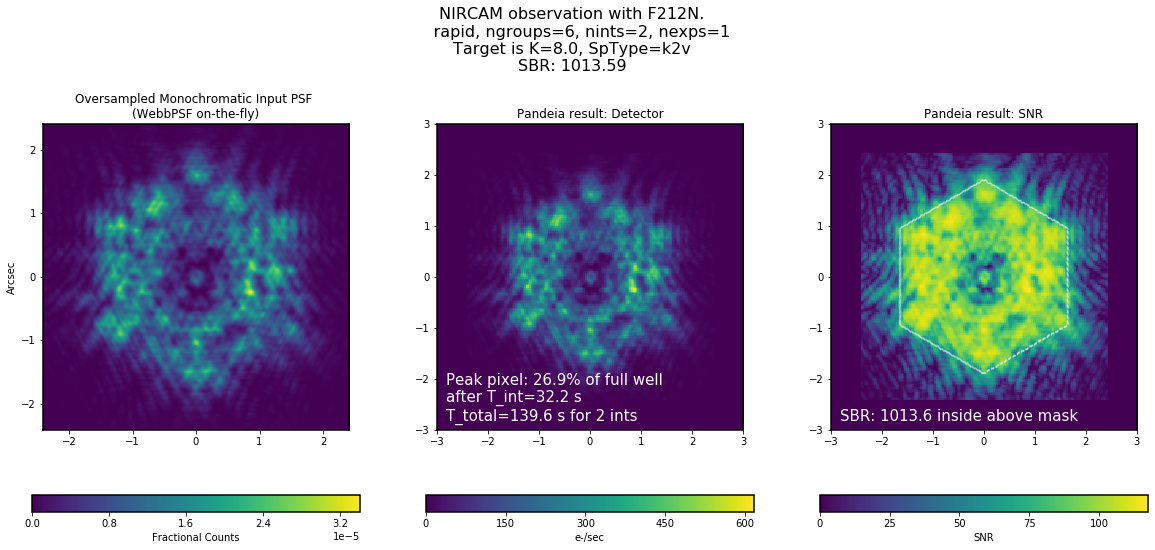

In [23]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=8, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=6, nint=2)
wfsc.configure_telescope(defocus_waves=8)  # Waves at 2 microns
results_nircam_wl8 = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam_wl8)

For cross check with Pandeia directly - see ETC notebook [55449](https://jwst.etc.stsci.edu/workbook.html?wb_id=55449#), which uses the SW_TS mode. (Ask Marshall to add you if you don't have access). That allows direct simulation of weak lenses in Pandeia. 

In [24]:
results_nircam_wl8['information']

{'calc_type': 'image',
 'exposure_specification': {'det_type': 'h2rg',
  'pattern': 'pattern_name',
  'ngroup': 6,
  'nint': 2,
  'nexp': 1,
  'tframe': 10.73677,
  'tfffr': 0.0,
  'nframe': 1,
  'subarray': 'full',
  'nskip': 0,
  'nprerej': 0,
  'npostrej': 0,
  'nreset1': 0,
  'nreset2': 1,
  'ndrop1': 0,
  'ndrop3': 0,
  'nsample': 1,
  'nsample_skip': 0,
  'frame0': False,
  'tgroup': 10.73677,
  'measurement_time': 107.3677,
  'exposure_time': 139.57801,
  'saturation_time': 64.42062,
  'duty_cycle': 0.7692307692307692,
  'total_exposure_time': 139.57801,
  'total_integrations': 2,
  'nramps': 2}}

SBR: 1013.5901089840493
Mean count rate within mask: 191.5 e-/sec
Total count rate: 2091837.9 e-/sec


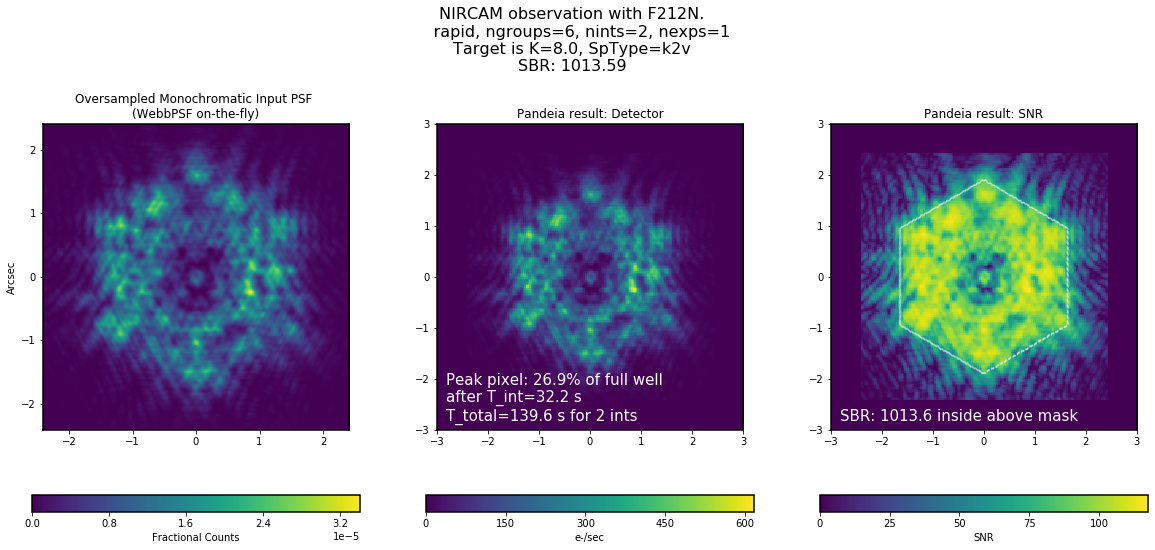

In [25]:
# This is a duplicate copy of the function from jwst_pancake/wfsc.py
# Edit this here for debugging or modifiying what this function does.

from jwst_pancake.wfsc import (display_one_image, colorbar_setup_helper,
    calc_sbr, assess_well_fraction, describe_obs)
def display_mimf_etc_results(results, verbose=True):

    
    fig = plt.figure(figsize=(20,9))
    plt.subplots_adjust(top=0.8)

    # Display PSF
    ax1=plt.subplot(131)
    display_one_image(results['psf']['int'], results['psf']['pix_scl'])
    #plt.imshow(results['psf']['int'], vmin=0, extent=extent)
    plt.title("Oversampled Monochromatic Input PSF \n(WebbPSF on-the-fly)")
    plt.ylabel("Arcsec")
    colorbar_setup_helper(label='Fractional Counts', mappable=ax1.images[0])

    # Display detector image
    ax2=plt.subplot(132)
    display_one_image(results['2d']['detector'], results['psf']['pix_scl']*results['psf']['upsamp'])
    plt.title("Pandeia result: Detector")
    colorbar_setup_helper(label='e-/sec', mappable=ax2.images[0])
    well_fraction, inttime = assess_well_fraction(results)
    ax2.text(0.03, 0.03, "Peak pixel: {:.1f}% of full well\nafter T_int={:.1f} s\nT_total={:.1f} s for {} ints".format(
        well_fraction*100, inttime,
        results['information']['exposure_specification']['exposure_time'],
        results['information']['exposure_specification']['nint']
    ), color='white',
        transform=ax2.transAxes, fontsize=15)

    SBR, mask = calc_sbr(results, return_mask=True)
    results['mask']=mask
    results['SBR']=SBR
    if verbose:
        print(f"SBR: {SBR}")
        print(f"Mean count rate within mask: {(results['2d']['detector'][mask]).mean():.1f} e-/sec")
        print(f"Total count rate: {(results['2d']['detector']).sum():.1f} e-/sec")

        
    # Display SNR
    ax3=plt.subplot(133)
    display_one_image(results['2d']['snr'], results['psf']['pix_scl']*results['psf']['upsamp'])

    halfsize = results['2d']['snr'].shape[0]/2 *results['psf']['pix_scl']*results['psf']['upsamp']
    extent= [-halfsize, halfsize, -halfsize, halfsize]


    ax3.contour(mask, extent=extent, colors='white', linewidths=1, alpha=0.25, linestyles="--")
    plt.title("Pandeia result: SNR")
    colorbar_setup_helper(label='SNR', mappable=ax3.images[0])


    ax3.text(0.03, 0.03, "SBR: {:.1f} inside above mask".format(SBR), color='white',
            transform=ax3.transAxes, fontsize=15)

    description = describe_obs(results['input']) + "\nSBR: {:.2f}".format(SBR)
    plt.suptitle(description, fontsize=16)

    if 'saturated' in results['warnings']:
        plt.text(0.1, 0.1, results['warnings']['saturated'], color='red',
                transform=fig.transFigure, fontsize=18)
    elif 'nonlinear' in results['warnings']:
        plt.text(0.1, 0.1, results['warnings']['nonlinear'], color='darkorange',
                transform=fig.transFigure, fontsize=18)
        
display_mimf_etc_results(results_nircam_wl8)

In [26]:
(results_nircam_wl8['2d']['detector'][results_nircam_wl8['mask']]).mean()

191.47343466114611

In [27]:
(results_nircam_wl8['2d']['detector'][results_nircam_wl8['mask']]).max()

617.0490483751317

In [28]:
results_nircam_wl8['psf'] = jwst_pancake.pandeia_subclasses.latest_on_the_fly_PSF

In [29]:
res

NameError: name 'res' is not defined

> <ipython-input-29-c08785e04264>(1)<module>()
----> 1 res

ipdb> quit


In [ ]:
jwst_pancake.pandeia_subclasses.latest_on_the_fly_PSF

In [ ]:
webbpsf.display_psf(jwst_pancake.pandeia_subclasses.latest_on_the_fly_PSF)

In [ ]:
results_nircam_wl8

In [ ]:
%pdb

To achieve SBR > 1500 in shorter exposures, it works better to use around a 7th magnitude star. 

In [ ]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=7.0, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=8, nint=2, readmode='rapid') 
wfsc.configure_telescope(defocus_waves=8)  # Waves at 2 microns
results_nircam_wl8 = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam_wl8)

# MIMF PSF calculations

MIMF target SBR is >1500 for NIRCam and NIRISS, > 750 for FGS, NIRSpec, and MIRI.

In [ ]:
wfsc.configure_telescope(defocus_waves=4)  # Waves at 2 microns

## NIRCam with 4 waves, for MIMF

Required SBR is > 1500 for NIRCam. 
Target star K mag range is 8.0 to 9.0.

8.5th mag star takes about 300 s to reach SBR 1500. 

In [ ]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=8.5, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=6, nint=4)
results_nircam = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam)

In [ ]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=8.5, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=6, nint=4)
results_nircam = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam)

8.0th mag star saves a little time. Still works well with NGROUPS>=4. 

In [ ]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=8.0, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=5, nint=4)
results_nircam_nint4 = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam_nint4)

7.5th mag would also be workable and is faster, but requires NGROUPS < 4 which is less than we typically want for ramp fits. 

In [ ]:
calcinfo = pcengine.load_calculation(pcengine.get_template('wfsc_nircam_mimf.json'))
wfsc.configure_star(calcinfo, kmag=7.5, sptype='k2v')
wfsc.configure_readout(calcinfo, ngroup=3, nint=4)
results_nircam_nint4 = pcengine.perform_calculation(calcinfo)
display_mimf_etc_results(results_nircam_nint4)

## NIRISS with 4 waves defocus, for MIMF

Required SBR is > 1500 for NIRISS. 
Target star K mag range is 12.5 to 13.5.

NIRISS has much broader spectral bandwidth in F158M, and needs much fainter stars, hence 12.5 to 13.5 mag. 

In [ ]:
calcinfo_niriss = pcengine.load_calculation(pcengine.get_template('wfsc_niriss_mimf.json'))
wfsc.configure_star(calcinfo_niriss, kmag=13, sptype='k2v')
wfsc.configure_readout(calcinfo_niriss, ngroup=5, nint=6, readmode='nisrapid')
results_niriss = pcengine.perform_calculation(calcinfo_niriss)

In [ ]:
display_mimf_etc_results(results_niriss)

In [ ]:
calcinfo_niriss = pcengine.load_calculation(pcengine.get_template('wfsc_niriss_mimf.json'))
wfsc.configure_star(calcinfo_niriss, kmag=12.5, sptype='k2v')
wfsc.configure_readout(calcinfo_niriss, ngroup=4, nint=6, readmode='nisrapid')
results_niriss = pcengine.perform_calculation(calcinfo_niriss)
display_mimf_etc_results(results_niriss)

## NIRSpec with 4 waves defocus, for MIMF

<font color='red'>*Warning - NIRSpec imaging not officially supported by the released Pandeia ETC code.  The following is done by adapting the NIRSpec TA modes. This is probably OK, but may need more careful cross checking by the NIRSpec team.*</font>

Required SBR is > 750 for NIRSpec. 
Target star K mag range is ???

The F110W filter is very broad bandwidth, and NIRSpec pixels are spatially large, therefore we expect to need fainter stars for full-frame exposures. On the other hand, the SUB32 subarray for the square aperture reads out very fast, so we can use much brighter stars. 

### NIRSpec Field point 1: through the S1600 square aperture

In [ ]:
calcinfo_nirspec_square = pcengine.load_calculation(pcengine.get_template('wfsc_nirspec_mimf_s1600a1.json'))

wfsc.configure_star(calcinfo_nirspec_square, kmag=8.5, sptype='k2v')
wfsc.configure_readout(calcinfo_nirspec_square, ngroup=6, nint=20)

results_nirspec_square = pcengine.perform_calculation(calcinfo_nirspec_square)

display_mimf_etc_results(results_nirspec_square)

In [ ]:
calcinfo_nirspec_square = pcengine.load_calculation(pcengine.get_template('wfsc_nirspec_mimf_s1600a1.json'))

wfsc.configure_star(calcinfo_nirspec_square, kmag=10, sptype='k2v')
wfsc.configure_readout(calcinfo_nirspec_square, ngroup=20, nint=20)

results_nirspec_square = pcengine.perform_calculation(calcinfo_nirspec_square)

display_mimf_etc_results(results_nirspec_square)

### NIRSpec Field points 2 through 5:  through the MSA

If we want to avoid saturating in 4 groups on a full frame exposure, we need a star no brigher than around 15th mag. 
(Though note, in this particular calculation that's largely driven by one particularly bright speckle in the PSF, as shown below. Still, we need to allow for that case since it's a plausible WFE distribution - the PSF won't be totally spatially uniform.)

The calculation of how much SBR is achieved is in this case compromised, by the blockage from the MSA array. If we simply follow these values we need undesirably long exposures to reach SBR>750 on average inside the aperture. 

<font color='red'>TODO: Update SBR calculation function to better handle this case.</font>

In [ ]:
calcinfo_nirspec_msa = pcengine.load_calculation(pcengine.get_template('wfsc_nirspec_mimf_msa.json'))

wfsc.configure_star(calcinfo_nirspec_msa, kmag=15, sptype='k2v')
wfsc.configure_readout(calcinfo_nirspec_msa, ngroup=4, nint=10)

results_nirspec_msa = pcengine.perform_calculation(calcinfo_nirspec_msa)

display_mimf_etc_results(results_nirspec_msa)

In [ ]:
calcinfo_nirspec_msa = pcengine.load_calculation(pcengine.get_template('wfsc_nirspec_mimf_msa.json'))

wfsc.configure_star(calcinfo_nirspec_msa, kmag=15, sptype='k2v')
wfsc.configure_readout(calcinfo_nirspec_msa, ngroup=4, nint=50)

results_nirspec_msa = pcengine.perform_calculation(calcinfo_nirspec_msa)

display_mimf_etc_results(results_nirspec_msa)

## MIRI with 4 waves defocus, for MIMF

Required SBR is > 750 for MIRI. 
Target star K mag range is 10.5 - 11.5.

Broadband F560W filter is wide, but on the other hand stars are getting fainter at these wavelengths. Around K=11 works well. 

Remember, "4 waves defocus" at 2 microns is much less than that at 5, so the PSF is not so defocused. 


In [ ]:
calcinfo_miri = pcengine.load_calculation(pcengine.get_template('wfsc_miri_mimf.json'))
wfsc.configure_star(calcinfo_miri, kmag=10.5, sptype='k2v')
wfsc.configure_readout(calcinfo_miri, ngroup=20, nint=2, readmode='fast')
results_miri = pcengine.perform_calculation(calcinfo_miri)
display_mimf_etc_results(results_miri)

In [ ]:
calcinfo_miri = pcengine.load_calculation(pcengine.get_template('wfsc_miri_mimf.json'))
wfsc.configure_star(calcinfo_miri, kmag=11, sptype='k2v')
wfsc.configure_readout(calcinfo_miri, ngroup=30, nint=2, readmode='fast')
results_miri = pcengine.perform_calculation(calcinfo_miri)
display_mimf_etc_results(results_miri)

Slightly brighter at 9.5 is also workable, but requires fairly short ramps. JDox page on best practices for MIRI imaging recommends longer ramps. Minimum workable is 5 groups, and ideally should be much longer than that, reportedly. The following is probably not preferable to the above, especially since the above exposure times are already relatively short. 

In [ ]:
calcinfo_miri = pcengine.load_calculation(pcengine.get_template('wfsc_miri_mimf.json'))
wfsc.configure_star(calcinfo_miri, kmag=9.5, sptype='k2v')
wfsc.configure_readout(calcinfo_miri, ngroup=10, nint=2, readmode='fast')
results_miri = pcengine.perform_calculation(calcinfo_miri)
display_mimf_etc_results(results_miri)

## FGS with 4 waves defocus, for MIMF

Required SBR is > 750 for FGS.

<font color='red'>**Note:** *FGS is not supported by Pandeia and is not available in any official capacity.  The Pandeia dev team was explicitly told that FGS is out of scope by JWSTMO.* In order for the following to work, you will need a modified copy of the Pandeia refdata from Marshall. This has not been benchmarked against anything and there is no guarantee of correctness. </font> 


Calculating FGS PSFs requires a special hacked-up version of both the Pandeia refdata and the `pandeia.engine` code, developed by Perrin. The engine code modifications are "monkey patched" in automatically when the `pandeia_coronagraphy.wfsc` module is loaded.  FGS simulations are implemented in a very quick and dirty way as a heavily cut-down version of the NIRISS setup. No performance guarantees provided, and this has not been benchmarked against *anything whatsoever*. But is likely to be "reasonably correct-ish", within an order of magnitude.

**By agreement between Perrin & Laidler, this version of the refdata and engine code is prohibited from any wider distribution outside of the STScI Telescopes group.** We don't want to give anyone else the impression that there is any official FGS support available in Pandeia. 


### FGS full frame imaging (i.e. FGS External Calibration template)

We consider the case of FGS full-frame images, which we take as being equivalent to the NISRAPID mode. <font color="red">TODO check this assumption</font>

In [ ]:
calcinfo_fgs = pcengine.load_calculation(pcengine.get_template('wfsc_fgs_mimf.json'))
wfsc.configure_star(calcinfo_fgs, kmag=15, sptype='k2v')
wfsc.configure_readout(calcinfo_fgs, ngroup=3, nint=4, readmode='nisrapid')
results_fgs = pcengine.perform_calculation(calcinfo_fgs)
display_mimf_etc_results(results_fgs)

Note, the left panel looks weird in the above compared to the other two panels. That's OK. In this case it is showing what the monochromatic defocused PSF looks like at 5.0 microns at the red end of the bandpass, but the broadband PSF is mostly  dominated by the shorter wavelengths. Because of the stellar SED. I checked this in detail in another notebook and it all seems to be OK. It's just especially unhelpful to show the monochromatic PSF in the left panel in this case. Makes less of a difference than for any other instrument. 

In [ ]:
calcinfo_fgs = pcengine.load_calculation(pcengine.get_template('wfsc_fgs_mimf.json'))
wfsc.configure_star(calcinfo_fgs, kmag=15.5, sptype='k2v')
wfsc.configure_readout(calcinfo_fgs, ngroup=5, nint=4, readmode='nisrapid')
results_fgs = pcengine.perform_calculation(calcinfo_fgs)
display_mimf_etc_results(results_fgs)

### FGS track-mode postage stamps (32x32 subarray)

<font color='red'> Need to double check what the appropriate integration time to use here is!</font>

In [ ]:
calcinfo_fgs = pcengine.load_calculation(pcengine.get_template('wfsc_fgs_mimf.json'))
calcinfo_fgs['configuration']['detector']['subarray'] = 'sub32'

wfsc.configure_star(calcinfo_fgs, kmag=10, sptype='k2v')
wfsc.configure_readout(calcinfo_fgs, ngroup=4, nint=4, readmode='nisrapid')
results_fgs = pcengine.perform_calculation(calcinfo_fgs)
display_mimf_etc_results(results_fgs)

In [ ]:
calcinfo_fgs = pcengine.load_calculation(pcengine.get_template('wfsc_fgs_mimf.json'))
calcinfo_fgs['configuration']['detector']['subarray'] = 'sub32'

wfsc.configure_star(calcinfo_fgs, kmag=11, sptype='k2v')
wfsc.configure_readout(calcinfo_fgs, ngroup=4, nint=4, readmode='nisrapid')
results_fgs = pcengine.perform_calculation(calcinfo_fgs)
display_mimf_etc_results(results_fgs)